## Imports

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()


## Plots of energy production

Shows the difference in energy production at different locations

                     pv_measurement
time                               
2019-06-02 22:00:00            0.00
2019-06-02 23:00:00            0.00
2019-06-03 00:00:00            0.00
2019-06-03 01:00:00            0.00
2019-06-03 02:00:00           19.36


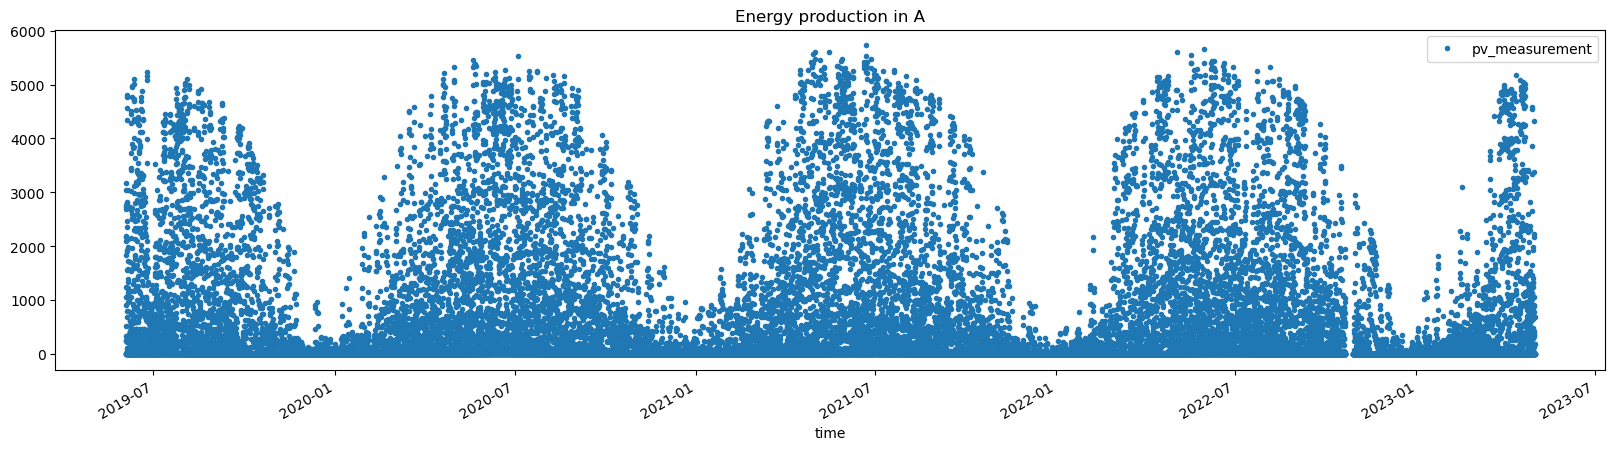

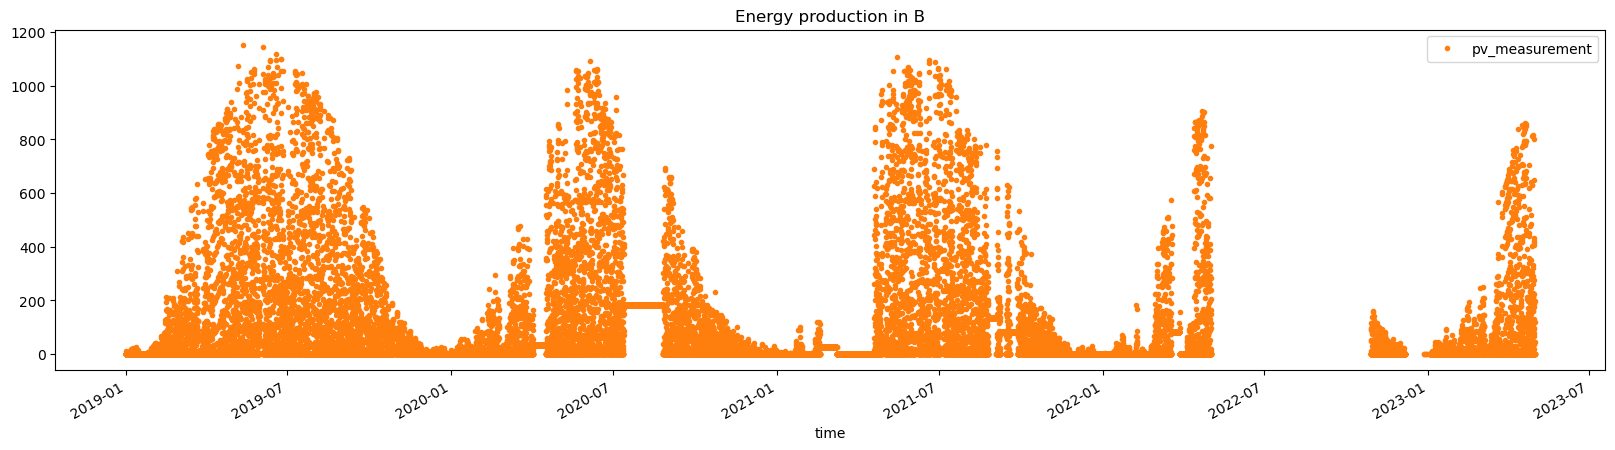

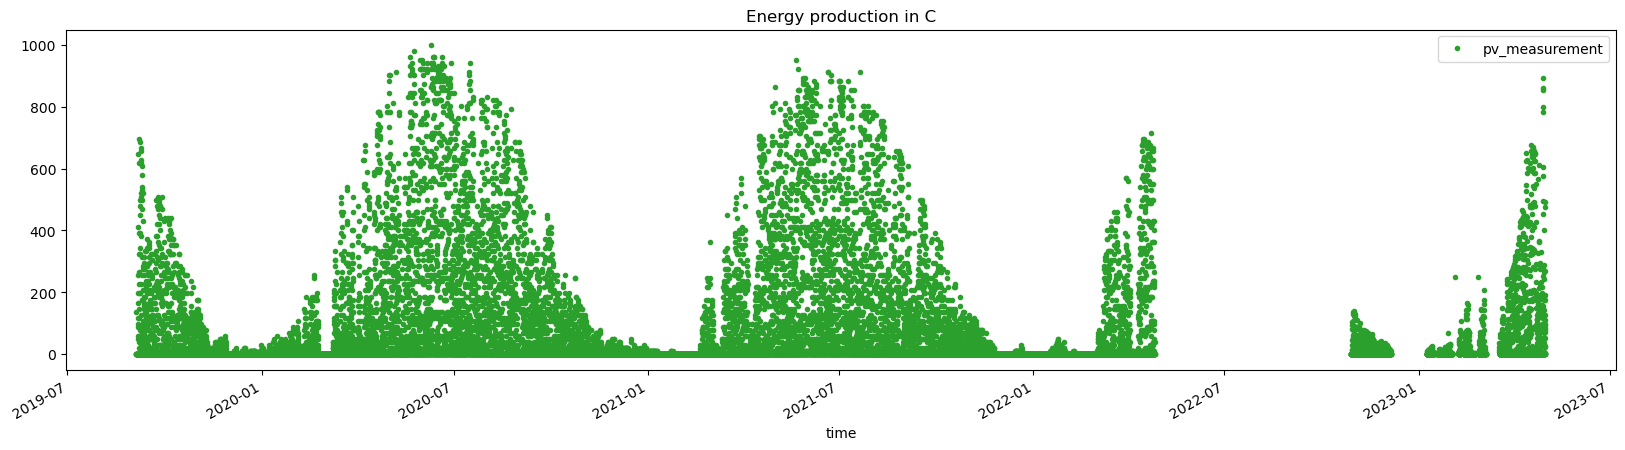

In [284]:
def load_and_plot_energy_production(dataset_path, title, color_index):
    df = pd.read_parquet(dataset_path)
    df.set_index('time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.plot(
        style='.',
        figsize=(20, 5),
        color=color_pal[color_index],
        title=title
    )
    return df

# Load and plot each dataset, while storing the DataFrames
train_targets_A = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet', 
    'Energy production in A', 
    0
)

train_targets_B = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/B/train_targets.parquet', 
    'Energy production in B', 
    1
)

train_targets_C = load_and_plot_energy_production(
    '/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/C/train_targets.parquet', 
    'Energy production in C', 
    2
)
print(train_targets_A.head())



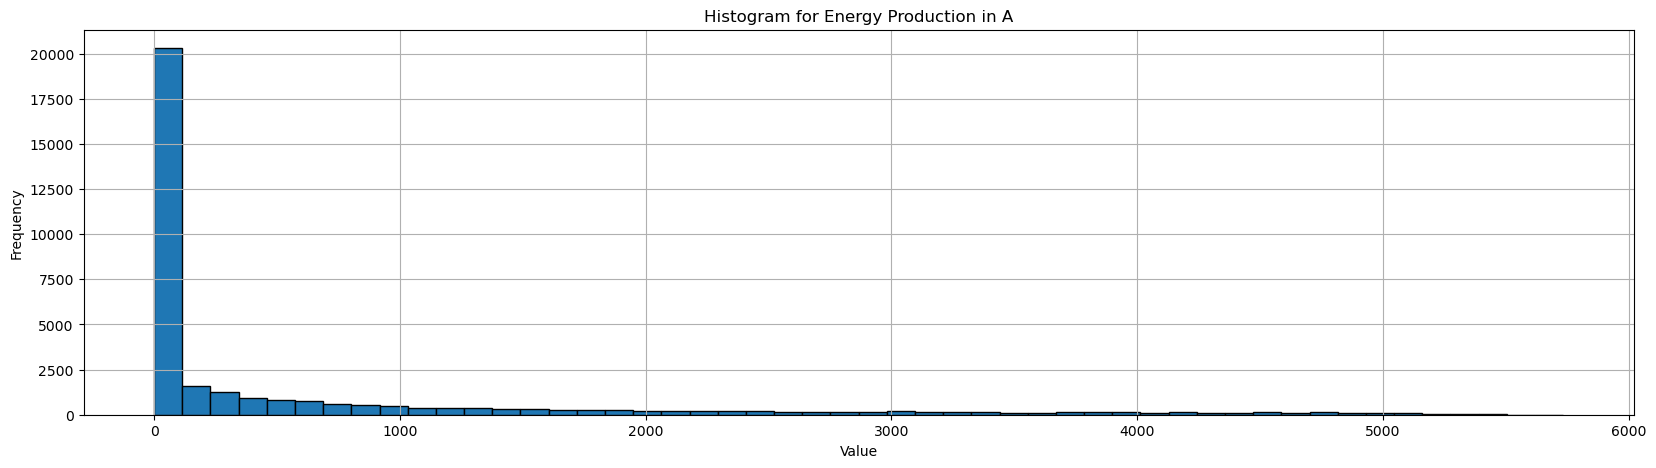

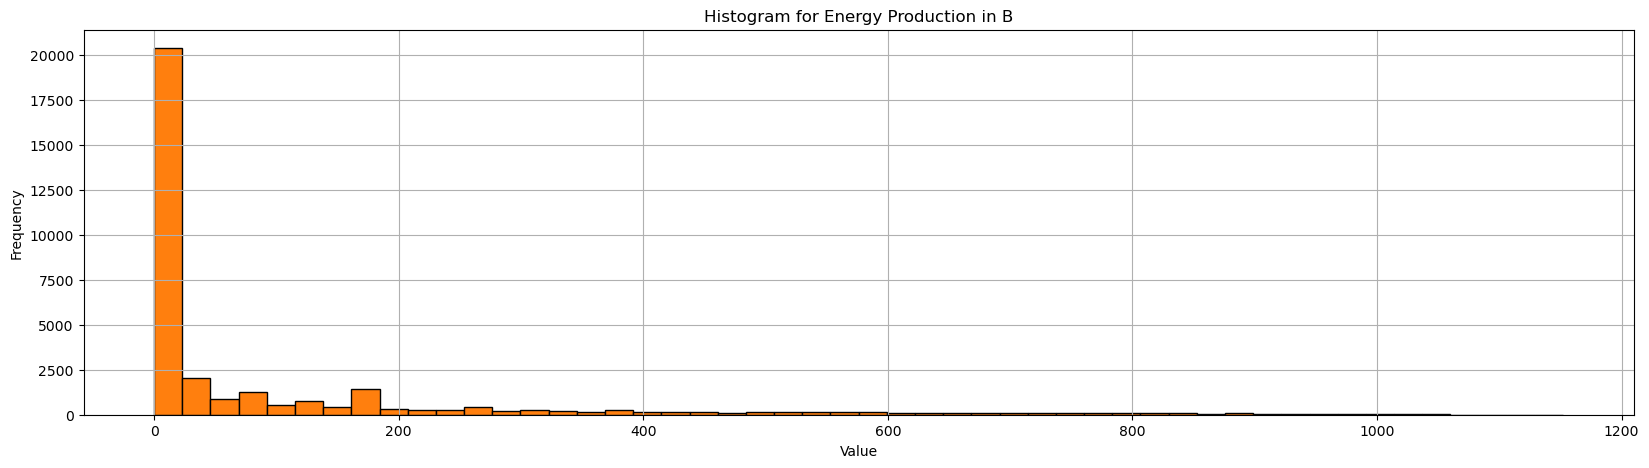

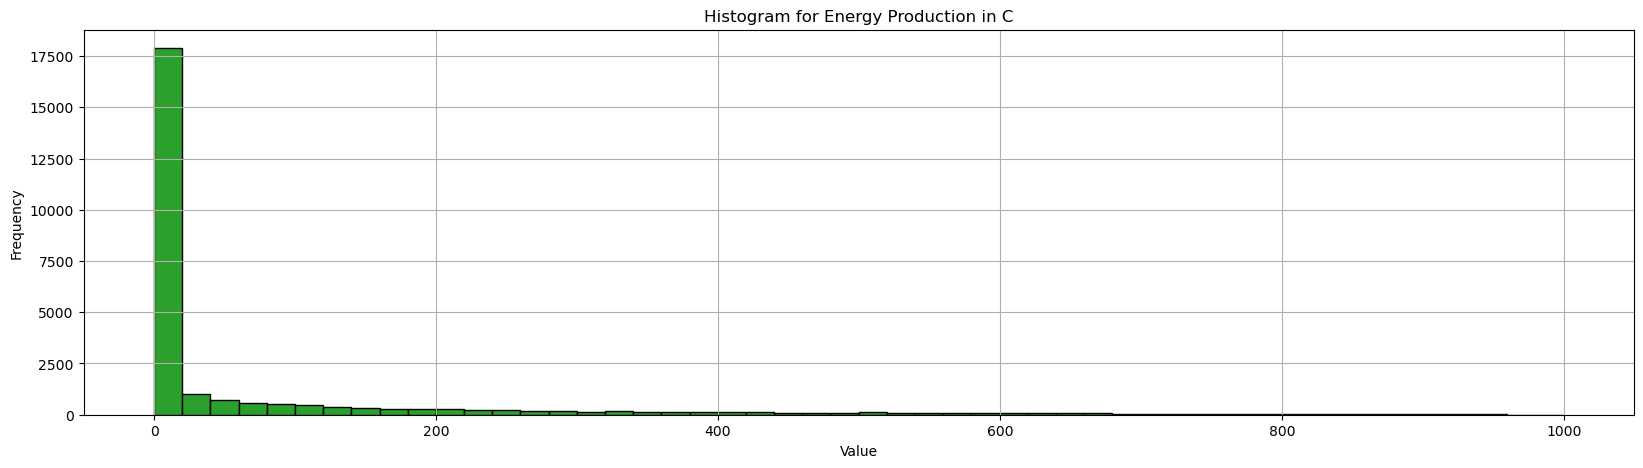

In [285]:
def plot_histogram(df, title, color_index):
    df.hist(
        figsize=(20, 5),
        color=color_pal[color_index],
        bins=50,
        edgecolor='black'
    )
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot histograms for each dataset
plot_histogram(train_targets_A, 'Histogram for Energy Production in A', 0)
plot_histogram(train_targets_B, 'Histogram for Energy Production in B', 1)
plot_histogram(train_targets_C, 'Histogram for Energy Production in C', 2)


In [286]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
train_targets_A = train_targets_A.sort_index()

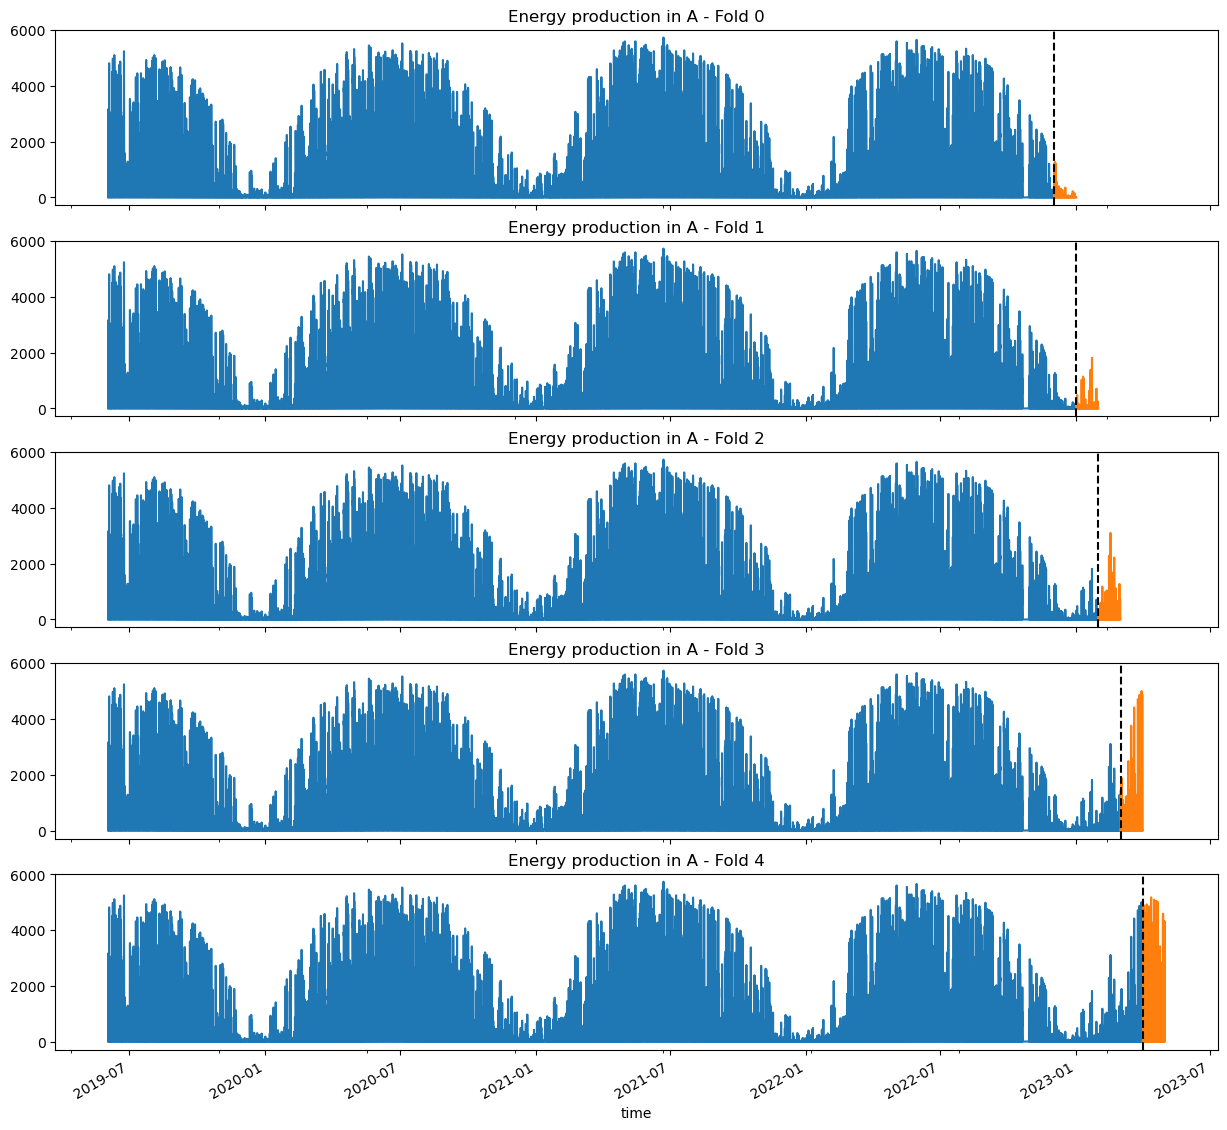

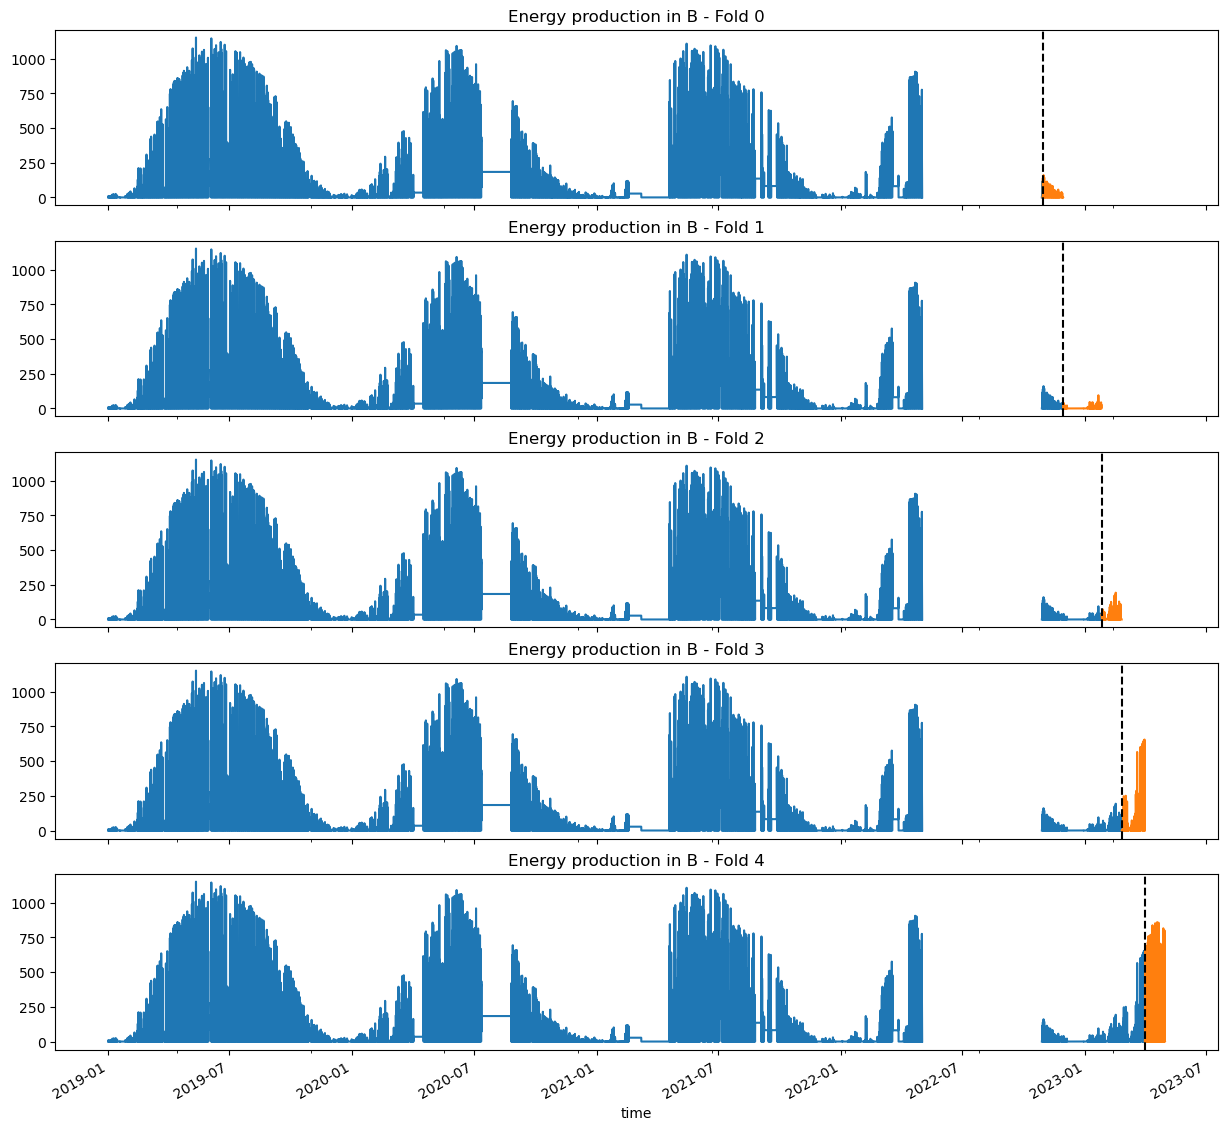

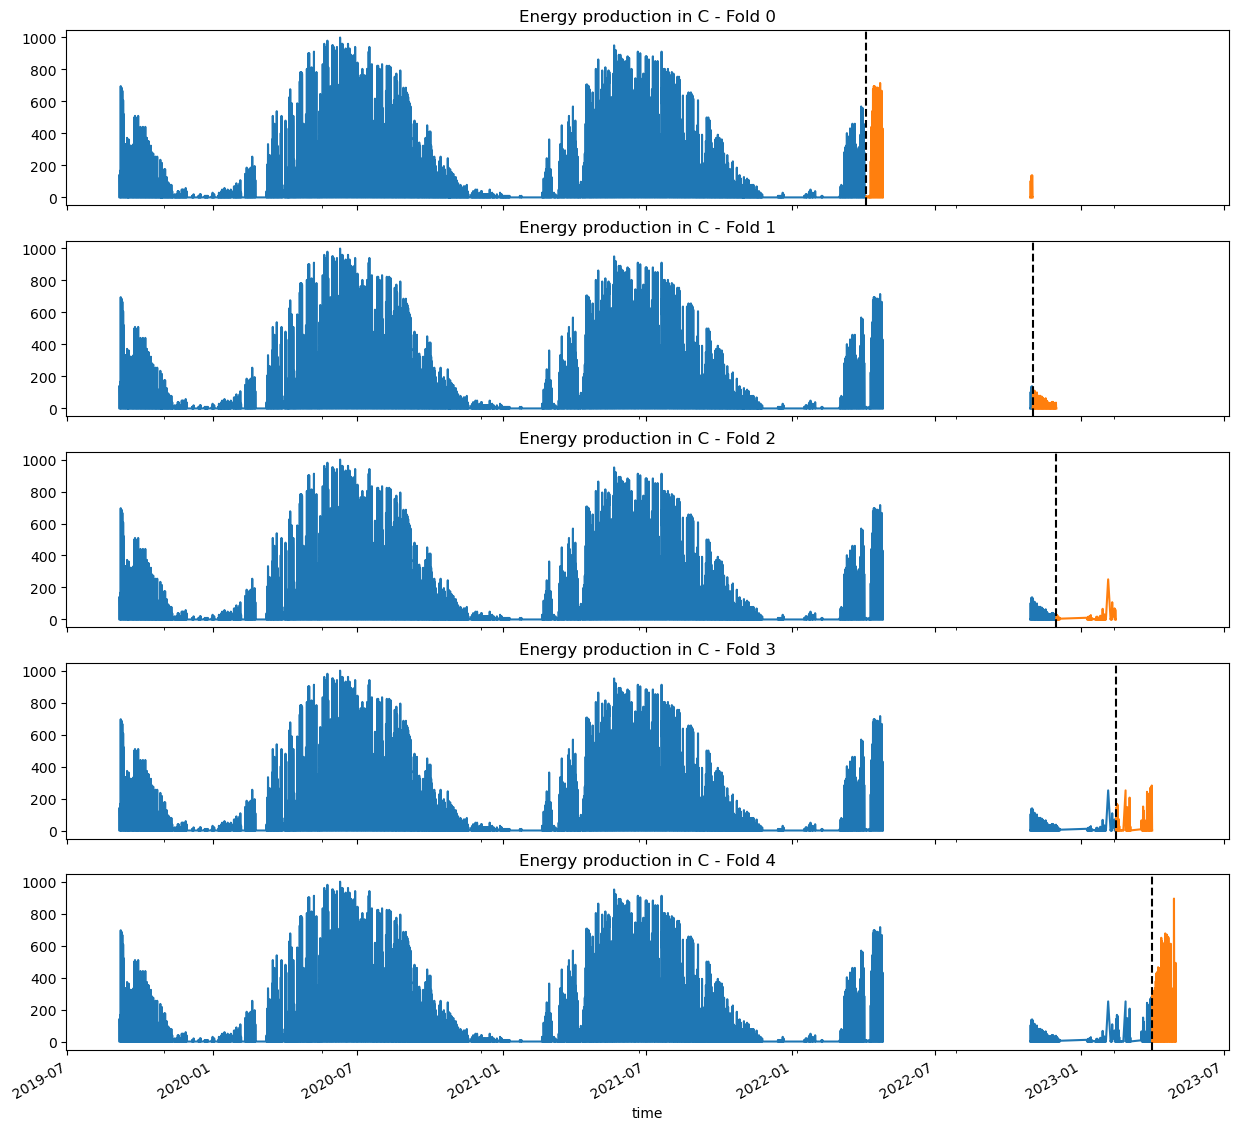

In [287]:
def time_series_split_and_plot(df, title):
    tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
    df = df.sort_index()

    fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train['pv_measurement'].plot(ax=axs[fold],
                                     label='train', title=f'{title} - Fold {fold}')
        test['pv_measurement'].plot(ax=axs[fold], label='test')

        axs[fold].axvline(test.index.min(), color='black', linestyle='--')  
        fold += 1


# Apply TimeSeriesSplit and plot for each dataset
time_series_split_and_plot(train_targets_A, 'Energy production in A')
time_series_split_and_plot(train_targets_B, 'Energy production in B')
time_series_split_and_plot(train_targets_C, 'Energy production in C')

In [288]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


In [289]:
def add_lags(df):
    target_map = df['pv_measurement'].to_dict()
    df['lag 1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag 2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag 3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [290]:
def train_and_evaluate(df, title):
    tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
    df = df.sort_index()

    fold = 0
    preds = []
    scores = []

    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train = create_features(train)
        test = create_features(test)

        FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                    'lag 1', 'lag 2', 'lag 3']
        TARGET = 'pv_measurement'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:linear',
                               max_depth=3,
                               learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

    print(f'{title} - score across folds: {np.mean(scores):0.4f};')
    print(f'{title} - fold scores are: {scores}')



In [291]:
train_targets_A = create_features(add_lags(train_targets_A))
train_targets_B = create_features(add_lags(train_targets_B))
train_targets_C = create_features(add_lags(train_targets_C))

# Train and evaluate
train_and_evaluate(train_targets_A, 'Energy production in A')
# train_and_evaluate(train_targets_B, 'Energy production in B')
# train_and_evaluate(train_targets_C, 'Energy production in C')


[20:23:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1348.54208	validation_1-rmse:128.71572
[100]	validation_0-rmse:939.70144	validation_1-rmse:121.08819
[20:23:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1333.04396	validation_1-rmse:181.41795
[100]	validation_0-rmse:930.28321	validation_1-rmse:156.10919
[113]	validation_0-rmse:907.73947	validation_1-rmse:163.83495
[20:23:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1318.21380	va

In [292]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
train_targets_A = train_targets_A.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(train_targets_A):
    train = train_targets_A.iloc[train_idx]
    test = train_targets_A.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag 1', 'lag 2', 'lag 3']
    TARGET = 'pv_measurement'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[20:23:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1348.54208	validation_1-rmse:128.71572


[99]	validation_0-rmse:941.55853	validation_1-rmse:121.09185
[20:23:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1333.04396	validation_1-rmse:181.41795
[100]	validation_0-rmse:930.28321	validation_1-rmse:156.10919
[112]	validation_0-rmse:909.33349	validation_1-rmse:163.60653
[20:23:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1318.21380	validation_1-rmse:339.30823
[97]	validation_0-rmse:926.53316	validation_1-rmse:298.46970
[20:23:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in fa

In [293]:
print(f'score across folds: {np.mean(scores):0.4f};')
print(f'fold scores are: {scores}')

score across folds: 467.0188;
fold scores are: [96.69338621834245, 148.19321522074347, 284.1914287075555, 845.778664514364, 960.2371487904394]


## Predicting the future

In [294]:
df = create_features(train_targets_A)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag 1', 'lag 2', 'lag 3']

TARGET = 'pv_measurement'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[20:23:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1317.76754


[100]	validation_0-rmse:919.70402
[200]	validation_0-rmse:804.68655
[300]	validation_0-rmse:746.93462
[400]	validation_0-rmse:719.80592
[499]	validation_0-rmse:703.98815


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [295]:
df.index.max()


Timestamp('2023-04-30 23:00:00')

In [296]:
# Create future dataframe

future = pd.date_range('2023-03-01', '2023-03-31')
future_train_targets_A = pd.DataFrame(index=future)
future_train_targets_A['isFuture'] = True
train_targets_A['isFuture'] = False
future_and_current_A = pd.concat([train_targets_A, future_train_targets_A])
future_and_current_A = create_features(future_and_current_A)    
future_and_current_A = add_lags(future_and_current_A)






In [297]:
future_w_features_A = future_and_current_A.query('isFuture').copy()

In [298]:
future_w_features_A['pred'] = reg.predict(future_w_features_A[FEATURES])

In [299]:


future_w_features_A['pred'] = reg.predict(future_w_features_A[FEATURES])
future_w_features_A

,pv_measurement,lag 1,lag 2,lag 3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,pred
2023-03-01,NaN,0.0,0.0,0.0,0,2,1,3,2023,60,1,9,True,-77.803009
2023-03-02,NaN,0.0,0.0,0.0,0,3,1,3,2023,61,2,9,True,-77.803009
2023-03-03,NaN,0.0,0.0,0.0,0,4,1,3,2023,62,3,9,True,-55.992912
2023-03-04,NaN,0.0,0.0,0.0,0,5,1,3,2023,63,4,9,True,-55.992912
2023-03-05,NaN,0.0,0.0,0.0,0,6,1,3,2023,64,5,9,True,-55.992912
2023-03-06,NaN,0.0,0.0,0.0,0,0,1,3,2023,65,6,10,True,-55.992912
2023-03-07,NaN,0.0,0.0,0.0,0,1,1,3,2023,66,7,10,True,-55.992912
2023-03-08,NaN,0.0,0.0,0.0,0,2,1,3,2023,67,8,10,True,-42.083908
2023-03-09,NaN,0.0,0.0,0.0,0,3,1,3,2023,68,9,10,True,-42.083908
2023-03-10,NaN,0.0,0.0,0.0,0,4,1,3,2023,69,10,10,True,-42.083908


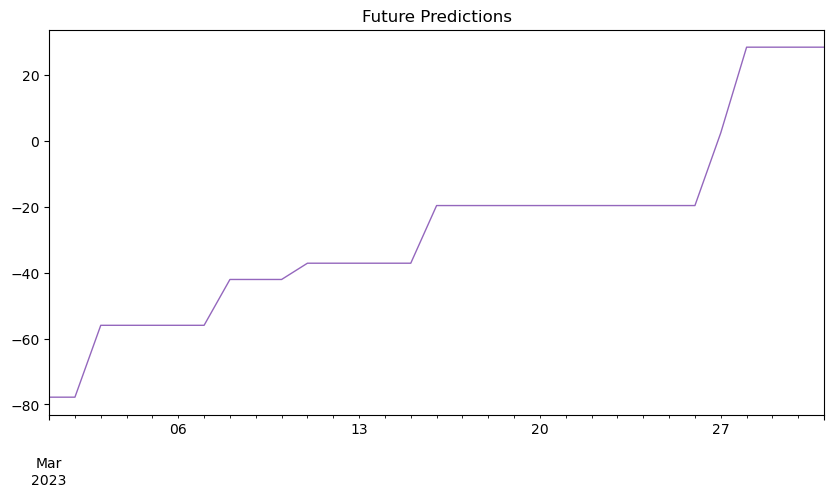

In [300]:
future_w_features_A['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()